<a href="https://colab.research.google.com/github/georgezefko/Bayesian_Deep_Learning/blob/main/STN_PCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import sys
import os

In [3]:
py_file_location = "/content/drive/My Drive/Bayesian_Deep_Learning/src/"
sys.path.append(os.path.abspath(py_file_location))

In [4]:
!pip install wandb -qqq


     |████████████████████████████████| 1.8 MB 10.3 MB/s 
     |████████████████████████████████| 144 kB 81.8 MB/s 
     |████████████████████████████████| 181 kB 93.1 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 


In [5]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import numpy as np
from torchvision.io import read_image
from PIL import Image 
import PIL 
import matplotlib.patches as patches
import make_dataset
import AffineTransform
from AffineTransform import make_affine_parameters
import compute_dim
from compute_dim import compute_conv_dim,compute_pool_dim
import SaveLoad
from SaveLoad import save_ckp
import wandb
import h5py


plt.ion()

In [6]:
path = '/content/drive/MyDrive/Bayesian_Deep_Learning/src/data/PCAM/'

In [ ]:
path

'/content/drive/MyDrive/Bayesian_Deep_Learning/src/data/PCAM/'

In [7]:
from torchvision.transforms.transforms import CenterCrop
class PatchCamelyon(Dataset):

    def __init__(self, path, mode='train', n_iters=None, augment=False):
        super().__init__()

        self.n_iters = n_iters

        assert mode in ['train', 'valid', 'test']
        base_name = "camelyonpatch_level_2_split_{}_{}.h5"

        print('\n')
        print("# " * 50)
        print('Loading {} dataset...'.format(mode))

        # Open the files
        h5X = h5py.File(os.path.join(path, base_name.format(mode, 'x')), 'r')
        h5y = h5py.File(os.path.join(path, base_name.format(mode, 'y')), 'r')

        # Read into numpy array
        self.X = np.array(h5X.get('x'))
        self.y = np.array(h5y.get('y')).reshape(-1, 1).astype(np.float32)


        print('Loaded {} dataset with {} samples'.format(mode, len(self.X)))
        print("# " * 50)

        if augment:
            self.transform = transforms.Compose([transforms.ToPILImage(),
                                                 transforms.ColorJitter(brightness=.5, saturation=.25,
                                                                        hue=.1, contrast=.5),
                                                 transforms.RandomAffine(10, (0.05, 0.05), fillcolor=255),
                                                 transforms.RandomHorizontalFlip(.5),
                                                 transforms.RandomVerticalFlip(.5),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize([0.6716241, 0.48636872, 0.60884315],
                                                                      [0.27210504, 0.31001145, 0.2918652])])
        else:
            self.transform = transforms.Compose([transforms.ToPILImage(),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize([0.6716241, 0.48636872, 0.60884315],
                                                                      [0.27210504, 0.31001145, 0.2918652])])

    def __getitem__(self, item):
        images = self.X[item]
        images = self.transform(images)
        labels = self.y[item]
        return images, labels
        # idx = item % self.__len__()
        # _slice = slice(idx*self.batch_size, (idx + 1) * self.batch_size)
        # images = self._transform(self.X[_slice])
        # labels = torch.tensor(self.y[_slice].astype(np.float32)).view(-1, 1)
        # return {'images': images, 'labels': labels}
        # #return images, labels

    def _transform(self, images):
        tensors = []
        for image in images:
            tensors.append(self.transform(image))
        return torch.stack(tensors)

    def __len__(self):
        return len(self.y)

In [8]:
dataset_train = PatchCamelyon(path, mode='train', augment=False)
dataset_valid = PatchCamelyon(path, mode='valid', )
dataset_test = PatchCamelyon(path, mode='test', )
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=256,shuffle =  True, num_workers=2)
val_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=256, shuffle = False, num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=256, shuffle = False, num_workers=2)



# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
Loading train dataset...
Loaded train dataset with 262144 samples
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 


# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
Loading valid dataset...
Loaded valid dataset with 32768 samples
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 


# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
Loading test dataset...
Loaded test dataset with 32768 samples
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([256, 3, 96, 96])
Labels batch shape: torch.Size([256, 1])


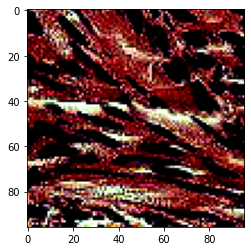

Label: tensor([1.])


In [9]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0]
label = train_labels[0]
plt.imshow(img.permute(1, 2, 0))
plt.show()
print(f"Label: {label}")


In [ ]:
def box_corner_to_center(boxes):
    """Convert from (upper-left, lower-right) to (center, width, height)."""
    #x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1, y1, x2, y2 = boxes[0], boxes[1], boxes[2], boxes[3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = torch.stack((cx, cy, w, h), axis=-1)
    return boxes

In [ ]:
def box_center_to_corner(boxes):
    """Convert from (center, width, height) to (upper-left, lower-right)."""
    #cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx, cy, w, h = boxes[0], boxes[1], boxes[2], boxes[3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes

In [ ]:
metastasis_box = [64.0, 32.0, 32.0, 64.0]

In [ ]:
boxes = torch.tensor(metastasis_box)
box_center_to_corner(box_corner_to_center(boxes)) == boxes

tensor([True, True, True, True])

In [ ]:
def bbox_to_rect(bbox, color):
    """Convert bounding box to matplotlib format."""
    # Convert the bounding box (upper-left x, upper-left y, lower-right x,
    # lower-right y) format to the matplotlib format: ((upper-left x,
    # upper-left y), width, height)
    return patches.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)

In [ ]:
img[0].shape

torch.Size([96, 96])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


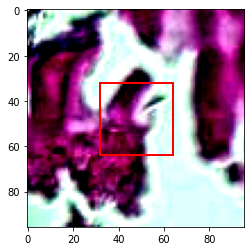

In [ ]:
fig = plt.imshow(img.permute(1,2,0))
fig.axes.add_patch(bbox_to_rect(metastasis_box, 'red'))
#fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'));

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


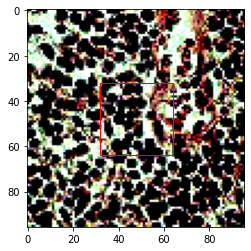

In [ ]:
# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(img.permute(1,2,0))

# Create a Rectangle patch
rect = patches.Rectangle((32, 32), 32, 32, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

In [31]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

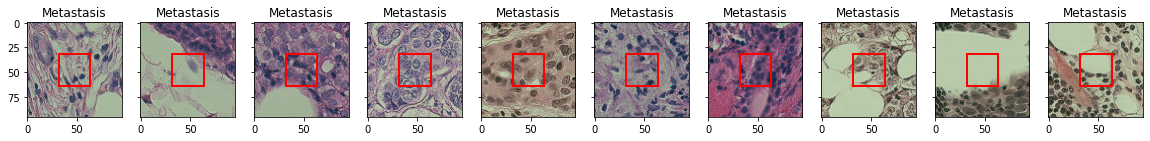

In [ ]:
input_tensor = []
transformed_input_tensor = []
for i,j in enumerate(train_labels):
  if j ==0:
      input_tensor.append(train_features[i])
  else:
      transformed_input_tensor.append(train_features[i])

fig,ax = plt.subplots(1,10,figsize=(20,15),sharey=True)

for i in range(len(transformed_input_tensor[:10])):
  img = convert_image_np(transformed_input_tensor[i])
  #img = img.permute(1,2,0)
  #ax[i].imshow((img * 255).to(torch.uint8))
  ax[i].imshow((img * 255).astype(np.uint8))
  ax[i].add_patch(bbox_to_rect(metastasis_box, 'red'))
  ax[i].set_title('Metastasis')

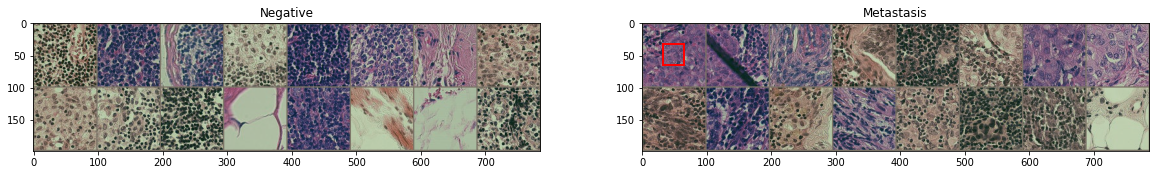

In [ ]:

input_tensor = []
transformed_input_tensor = []
for i,j in enumerate(train_labels):
  if j ==0:
      input_tensor.append(train_features[i])
  else:
      transformed_input_tensor.append(train_features[i])

in_grid = convert_image_np(
    torchvision.utils.make_grid([i.cpu() for i in input_tensor[:16]]))

out_grid = convert_image_np(
    torchvision.utils.make_grid([i.cpu() for i in transformed_input_tensor[:16]]))


# Plot the results side-by-side
f, axarr = plt.subplots(1, 2,figsize=(20,20))
axarr[0].imshow(in_grid)
axarr[0].set_title('Negative')

axarr[1].imshow(out_grid)
axarr[1].add_patch(bbox_to_rect(metastasis_box, 'red'))
axarr[1].set_title('Metastasis')

plt.ioff()
plt.show()

In [ ]:
out_grid[1].shape

(274, 3)

In [10]:
if torch.cuda.is_available():
      print("The code will run on GPU.")
else:
      print("The code will run on CPU.")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

The code will run on GPU.


In [11]:
height = train_features.shape[2]
width = train_features.shape[3]
channels = train_features.shape[1]
print(channels,height,width)

3 96 96


In [51]:
config = {
    "num_classes":2,
    "kernel_size": 3,
    "channels":channels,
    "enc_sizes" :[16,32],
    "loc_sizes" :[8,10],
    "padding" :0,
    "stride" :2, 
    "pool":2,
    "learning_rate": 0.01,
    "epochs": 5,
    "batch_size": 256,
    "crop_size":128
}


wandb.config ={
    
    "learning_rate": 0.001,
    "epochs": 20,
    "batch_size": 128}

In [58]:
def conv_block(in_f, out_f,pool,stride, *args, **kwargs):
    return nn.Sequential(
        nn.Conv2d(in_f, out_f, *args, **kwargs),
        nn.Conv2d(out_f, out_f, *args, **kwargs),
        nn.BatchNorm2d(out_f),
        nn.MaxPool2d(pool, stride),
        nn.ReLU(),
        
    )


class Base(nn.Module):
    def __init__(self, enc_sizes,pool,stride,kernel,pad):
        super().__init__()

        conv_blocks =[conv_block(in_f, out_f, pool=pool, stride=stride,kernel_size=kernel, padding=pad) 
                       for in_f, out_f in zip(enc_sizes, enc_sizes[1:])]

        self.base_net = nn.Sequential(*conv_blocks)
        

    def forward(self,x):
        x = self.base_net(x)
    
        return x


class STN(nn.Module):
    def __init__(self,loc_sizes,pool,stride,kernel,pad, parameterize=True):
        super().__init__()
    
        self.parameterize =parameterize 
        self.loc_sizes = loc_sizes
        
        
        conv_blocks =[conv_block(in_f, out_f, pool=pool,stride=stride,kernel_size=kernel, padding=pad) 
                        for in_f, out_f in zip(loc_sizes, loc_sizes[1:])]

        self.localization = nn.Sequential(*conv_blocks)
        

        # Regressor for the affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(loc_sizes[-1] *21 *21, 32),
            nn.ReLU(),
            nn.Linear(32, 2 * 1 if parameterize else 3 * 2),
        )
        
        self.fc_loc[-1].weight.data.zero_()
        if parameterize:
            bias = torch.tensor([0, 0], dtype=torch.float)
            self.fc_loc[-1].bias.data.copy_(bias[:2].view(-1))

        else:
            self.fc_loc[-1].bias.data.copy_(
                torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float)
            )
        

    def forward(self,x):
        xs = self.localization(x)
        #print(xs.shape)
        xs = xs.view(-1, self.loc_sizes[-1] * xs.shape[2] * xs.shape[3])

        theta = self.fc_loc(xs)

        if self.parameterize:
            theta = AffineTransform.make_affine_parameters(theta)
        else:
            theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size(), align_corners=True)
        x = F.grid_sample(x, grid)

        return x

class Net(nn.Module):
    def __init__(self, in_c, enc_sizes, loc_sizes,pool,stride,kernel,pad, n_classes,parameterize=True):
        super().__init__()
    
        self.enc_sizes = [in_c, *enc_sizes]
        self.loc_sizes = [in_c, *loc_sizes]
        self.kernel = kernel
        self.stride=stride
        self.pool = pool
        self.pad =pad

        self.parameterize = parameterize
        self.n_classes = n_classes
        
        self.base = Base(self.enc_sizes, self.pool,self.stride,self.kernel, self.pad)
        self.stn = STN(self.loc_sizes, self.pool,self.stride,self.kernel, self.pad, self.parameterize)
        self.fc1 = nn.Linear(
            self.enc_sizes[-1] *21*21 , 50
        )
        self.fc2 = nn.Linear(50, self.n_classes)
        

    def forward(self,x):
        # transform the input
        #print('input_stn',x.shape)
        x = self.stn(x)
        #print('stn_out',x.shape)

        x = self.base(x)
        #print('out_base',x.shape)
        
        #x = x.view(-1, self.enc_sizes[-1] * 4 * 4)
        #x = F.adaptive_max_pool2d(x,(1,1))
        x = x.flatten(1)
        #print(x.shape)
        #x = torch.mean(x)
        #print(x.shape)
        #x = F.adaptive_avg_pool2d(x, (1, 1))
       
        #print('exp',y.shape)
        #print('flat',x.shape)
        x = F.relu(self.fc1(x))
        #print('linea_out',x.shape)
        
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        #print('net_out',x.shape)
        

        return x



In [59]:
model = Net(
        config["channels"],
        config["enc_sizes"],
        config["loc_sizes"],
        config["pool"],
        config["stride"],
        config["kernel_size"],
        config["padding"],
        config["num_classes"],
        parameterize=True).to(device)

In [60]:
print(model)

Net(
  (base): Base(
    (base_net): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
        (1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (4): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
        (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (4): ReLU()
      )
    )
  )
  (stn): STN(
    (localization): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
        (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
        (2): BatchNorm2d(8, eps=1e-

In [61]:
from torchvision import models
from torchsummary import summary

# vgg = models.vgg16()
summary(model, (3, 96, 96))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 94, 94]             224
            Conv2d-2            [-1, 8, 92, 92]             584
       BatchNorm2d-3            [-1, 8, 92, 92]              16
         MaxPool2d-4            [-1, 8, 46, 46]               0
              ReLU-5            [-1, 8, 46, 46]               0
            Conv2d-6           [-1, 10, 44, 44]             730
            Conv2d-7           [-1, 10, 42, 42]             910
       BatchNorm2d-8           [-1, 10, 42, 42]              20
         MaxPool2d-9           [-1, 10, 21, 21]               0
             ReLU-10           [-1, 10, 21, 21]               0
           Linear-11                   [-1, 32]         141,152
             ReLU-12                   [-1, 32]               0
           Linear-13                    [-1, 2]              66
              STN-14            [-1, 3,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


In [56]:
640/8**2

10.0

In [ ]:
64*25

1600

In [57]:
np.sqrt(4410/10)

21.0

In [17]:
exp_data= next(iter(train_loader))[0]

In [18]:
exp_data.shape

torch.Size([256, 3, 96, 96])

In [36]:
loc_sizes = [3, *config["loc_sizes"]]

conv_blocks =[conv_block(in_f, out_f, pool = config["pool"],stride=config["stride"],kernel_size=config["kernel_size"], padding=config["padding"]) 
                       for in_f, out_f in zip(loc_sizes, loc_sizes[1:])]

localization = nn.Sequential(*conv_blocks)

In [20]:
loc_sizes[-1]

64

In [37]:
output_2 = localization(exp_data)

In [22]:
output_2.shape

torch.Size([256, 64, 8, 8])

In [38]:
output_2 = output_2.view(-1,64*8*8)

In [24]:
output_2.shape

torch.Size([256, 4096])

In [40]:
fc_loc = nn.Sequential(
            nn.Linear(loc_sizes[-1] * 8 *8, 32),
            nn.ReLU(),
            nn.Linear(32, 1 * 2),
        )

In [41]:
fc_loc[2].weight.data.zero_()


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]])

In [42]:
bias = torch.tensor([0.0, 0.0], dtype=torch.float)
fc_loc[-1].bias.data.copy_(bias[:2].view(-1))

tensor([0., 0.])

In [27]:
fc_loc[-1].bias.data.copy_(
                torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float)
            )

tensor([1., 0., 0., 0., 1., 0.])

In [43]:
theta = fc_loc(output_2)

In [ ]:
32768/32**2

32.0

In [ ]:
np.sqrt(16384/32)

22.627416997969522

In [45]:
theta  = make_affine_parameters(theta)

#theta = theta.view(-1, 2, 3)

In [46]:
grid = F.affine_grid(theta, exp_data.size(),align_corners =True)
x = F.grid_sample(exp_data, grid)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


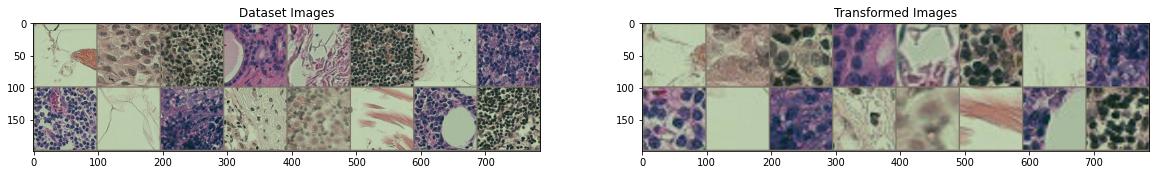

In [47]:
def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data

        input_tensor = exp_data.cpu()
        transformed_input_tensor = x.cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor[:16]))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor[:16]))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2,figsize=(20,20))
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')



# Visualize the STN transformation on some input batch
visualize_stn()
#wandb.log({'Final':wandb.Image(visualize_stn)})

plt.ioff()
plt.show()

In [ ]:
def wandb_pred(model, test_loader, device):
    # create a wandb Artifact to version each test step separately
    test_data_at = wandb.Artifact(
        "test_samples_" + str(wandb.run.id), type="Transformations"
    )
    # create a wandb.Table() in which to store predictions for each test step
    columns = ["Grid in", "Grid out"]
    test_table = wandb.Table(columns=columns)

    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)
        # for batch, (data,_) in enumerate(test_loader):
        # data = data.to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor)
        )

        # Plot the results side-by-side
        test_table.add_data(wandb.Image(in_grid), wandb.Image(out_grid))

    # log predictions table to wandb
    test_data_at.add(test_table, "Transformations")
    wandb.run.log_artifact(test_data_at)

In [62]:
optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])
criterion = nn.CrossEntropyLoss()

In [63]:
seed =0


checkpoint_path = "/content/drive/MyDrive/Bayesian_Deep_Learning/STN_MNIST/colab_Pcam_20_STN2_ver_1.pth"
best_model_path = "/content/drive/MyDrive/Bayesian_Deep_Learning/STN_MNIST/colab_best_Pcam_20_STN2__ver_1.pth"


valid_loss_min_input=0.1


# Set the seed for reproducibility
torch.manual_seed(seed)
np.random.seed(seed)



# initialize tracker for minimum validation loss
valid_loss_min = valid_loss_min_input
# initialize wandb
# wandb.init(
#     project="Bayesian DL",
#     name="Colab_Pcam_20_STN2_ver_1_par",
#     entity="zefko",
# )

for epoch in range(1, config["epochs"] + 1):

    #wandb.watch(model, optimizer, log="all", log_freq=1000)
    train_loss = 0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        target = torch.flatten(target.type(torch.LongTensor)).to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output,target)#F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        if batch_idx % 500 == 0:
            #wandb.log({"epoch": epoch, "Train loss": loss.item()})
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )

    

    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0

        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            target = torch.flatten(target.type(torch.LongTensor)).to(device)

            output = model(data)

            # sum up batch loss
            test_loss += criterion(output, target).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

            

        test_loss /= len(val_loader.dataset)

        # wandb.log(
        #     {
        #         "Validation loss": test_loss,
        #         "Validation_accuracy": 100.0 * correct / len(val_loader.dataset),
        #     }
        # )

        print(
            "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
                test_loss,
                correct,
                len(val_loader.dataset),
                100.0 * correct / len(val_loader.dataset),
            )
        )

    # # create checkpoint variable and add important data
    # checkpoint = {
    #     "epoch": epoch + 1,
    #     "valid_loss_min": test_loss,
    #     "state_dict": model.state_dict(),
    #     "optimizer": optimizer.state_dict(),
    # }

    # # save checkpoint
    # save_ckp(checkpoint, False, checkpoint_path, best_model_path)
    # # log the stn outputs
    # wandb_pred(model, train_loader, device)
    

    ## TODO: save the model if validation loss has decreased
    if test_loss <= valid_loss_min:
        print(
            "Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...".format(
                valid_loss_min, test_loss
            )
        )
        # save checkpoint as best model
        #save_ckp(checkpoint, True, checkpoint_path, best_model_path)
        valid_loss_min = test_loss


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


Train Epoch: 1 [0/262144 (0%)]	Loss: 0.773660
Train Epoch: 1 [128000/262144 (49%)]	Loss: 0.692743
Train Epoch: 1 [256000/262144 (98%)]	Loss: 0.695143

Test set: Average loss: 0.0027, Accuracy: 16369/32768 (50%)

Validation loss decreased (0.100000 --> 0.002708).  Saving model ...
Train Epoch: 2 [0/262144 (0%)]	Loss: 0.693820
Train Epoch: 2 [128000/262144 (49%)]	Loss: 0.693313
Train Epoch: 2 [256000/262144 (98%)]	Loss: 0.692977

Test set: Average loss: 0.0027, Accuracy: 16369/32768 (50%)

Validation loss decreased (0.002708 --> 0.002708).  Saving model ...
Train Epoch: 3 [0/262144 (0%)]	Loss: 0.693117


KeyboardInterrupt: ignored

In [ ]:

@torch.no_grad()
def test(test_loader):
    model.eval()
    correct = 0

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        

        ps = torch.exp(output)

        # Keep track of how many are correctly classified
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == target.view(*top_class.shape)
        correct += equals.type(torch.FloatTensor).sum().item()

    print(
        "\nTest set: Accuracy: {}/{} ({:.0f}%)\n".format(
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )



In [ ]:
test(test_loader)


Test set: Accuracy: 26998.0/32768 (82%)



In [ ]:
wandb.finish()

Train loss,▆▆▇▅▆▅▅▅▃██▆▃▅▂▁▇▄▇
Validation loss,█▁
Validation_accuracy,▁█
epoch,▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅█
Train loss,0.71216
Validation loss,0.01083
Validation_accuracy,49.83826
epoch,3


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


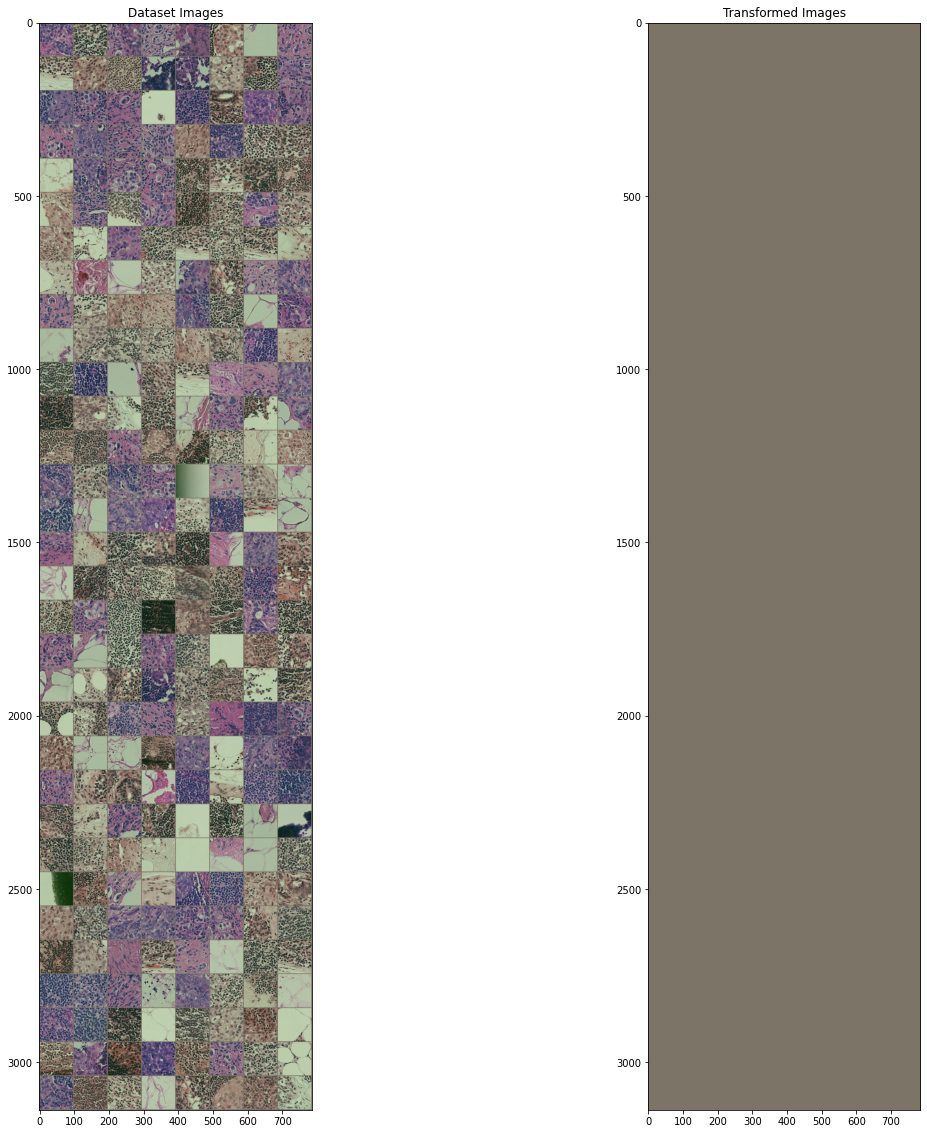

In [64]:
def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(val_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2,figsize=(20,20))
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')



# Visualize the STN transformation on some input batch
visualize_stn()
#wandb.log({'Final':wandb.Image(visualize_stn)})

plt.ioff()
plt.show()